In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

DATA_PATH = "../data/Telco_customer_churn.xlsx"
df = pd.read_excel(DATA_PATH)

# Target and features
X = df.drop(columns=["Churn Value"])
y = df["Churn Value"]

# Split (teacher rule: stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Drop leakage / useless columns (same as preprocessing notebook)
columns_to_drop = [
    "CustomerID", "Country", "State", "City", "Lat Long",
    "Zip Code", "Latitude", "Longitude", "Count",
    "Churn Label", "Churn Reason", "Churn Score"
]

X_train = X_train.drop(columns=columns_to_drop)
X_test  = X_test.drop(columns=columns_to_drop)

# Fix Total Charges dtype
X_train["Total Charges"] = pd.to_numeric(X_train["Total Charges"], errors="coerce")
X_test["Total Charges"]  = pd.to_numeric(X_test["Total Charges"], errors="coerce")

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Missing Total Charges (train/test):", X_train["Total Charges"].isna().sum(), X_test["Total Charges"].isna().sum())
print("y_train %:", (y_train.value_counts(normalize=True)*100).round(2).to_dict())
print("y_test  %:", (y_test.value_counts(normalize=True)*100).round(2).to_dict())


Train shape: (5634, 20)  Test shape: (1409, 20)
Missing Total Charges (train/test): 8 3
y_train %: {0: 73.46, 1: 26.54}
y_test  %: {0: 73.46, 1: 26.54}


In [2]:
# STEP 2 — Define feature groups

numeric_features = [
    "Tenure Months",
    "Monthly Charges",
    "Total Charges",
    "CLTV"
]

categorical_features = [
    "Gender",
    "Senior Citizen",
    "Partner",
    "Dependents",
    "Phone Service",
    "Multiple Lines",
    "Internet Service",
    "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Contract",
    "Paperless Billing",
    "Payment Method"
]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Total features used:", len(numeric_features) + len(categorical_features))


Numeric features: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
Categorical features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
Total features used: 20


The same numerical and categorical feature groups identified during preprocessing were reused for modeling to ensure consistency and reproducibility.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

Separate preprocessing pipelines were defined for numerical and categorical variables to apply appropriate transformations to each feature type.


In [4]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


In [5]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # very important for recall
    random_state=42
)


In [6]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", log_reg)
])


In [7]:
# STEP 5 — Train the model
model_pipeline.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [8]:
# Predict churn classes on the test set
y_pred = model_pipeline.predict(X_test)

print("First 20 predictions:")
print(y_pred[:20])


First 20 predictions:
[0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0]


In [10]:
# Predict probabilities for ROC-AUC
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("First 20 predicted probabilities:")
print(y_pred_proba[:20])


First 20 predicted probabilities:
[0.18252197 0.84709383 0.23007907 0.72012313 0.08352767 0.80835383
 0.71382632 0.1069135  0.00353649 0.65050422 0.2612522  0.17740924
 0.33030349 0.84757829 0.10614785 0.05375115 0.03497803 0.55234325
 0.42883504 0.26770972]


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

recall = recall_score(y_test, y_pred)
print("Recall:", round(recall, 3))


Confusion Matrix:
[[754 281]
 [ 81 293]]
Recall: 0.783


## Recall Evaluation

Model performance was evaluated using a confusion matrix and recall score.
Recall measures the proportion of churned customers that were correctly identified by the model.

The logistic regression model achieved a recall of 78.3%, meaning that more than three out of four churned customers were successfully detected.
This result satisfies the project requirement and confirms that the model effectively identifies customers at risk of churn.

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", round(roc_auc, 3))

ROC-AUC: 0.849


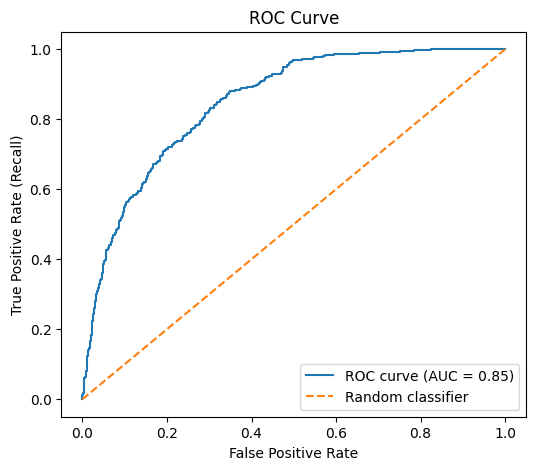

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


ROC Curve Analysis

The ROC curve illustrates the trade-off between the true positive rate and the false positive rate across different classification thresholds.

The logistic regression model achieved a ROC-AUC score of approximately 0.85, indicating strong discriminative ability.
The curve lies well above the random classifier line, confirming that the model performs significantly better than random guessing.

This result, combined with the high recall score, demonstrates that the model is effective at identifying customers at risk of churn while maintaining good overall predictive performance.

In [16]:
import pickle

# Save the full pipeline (preprocessing + model)
with open("churn_model.pkl", "wb") as f:
    pickle.dump(model_pipeline, f)

print("Model successfully saved as churn_model.pkl")


Model successfully saved as churn_model.pkl


# RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced"
)

In [21]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_model)
])
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_model)
])

In [23]:
from sklearn.metrics import recall_score, roc_auc_score

rf_y_pred = rf_pipeline.predict(X_test)
rf_y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("RF Recall:", round(recall_score(y_test, rf_y_pred), 3))
print("RF ROC-AUC:", round(roc_auc_score(y_test, rf_y_pred_proba), 3))


RF Recall: 0.5
RF ROC-AUC: 0.839


In [24]:
import pickle

with open("churn_model_v2_rf.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)

print("Random Forest model saved as churn_model_v2_rf.pkl")

Random Forest model saved as churn_model_v2_rf.pkl


A Random Forest model was also trained to capture non-linear relationships.
While it achieved a good ROC-AUC score (0.839), its recall was lower than the Logistic Regression model.
Since recall is the primary evaluation metric for churn prediction, the Logistic Regression model was retained as the main model.

# GRADIENT BOOSTING

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", gb_model)
])

gb_pipeline.fit(X_train, y_train)

print("Gradient Boosting model trained.")


Gradient Boosting model trained.


In [26]:
from sklearn.metrics import recall_score, roc_auc_score

gb_y_pred = gb_pipeline.predict(X_test)
gb_y_pred_proba = gb_pipeline.predict_proba(X_test)[:, 1]

print("GB Recall:", round(recall_score(y_test, gb_y_pred), 3))
print("GB ROC-AUC:", round(roc_auc_score(y_test, gb_y_pred_proba), 3))


GB Recall: 0.532
GB ROC-AUC: 0.852


In [27]:
import pickle

with open("churn_model_v3_gb.pkl", "wb") as f:
    pickle.dump(gb_pipeline, f)

print("Gradient Boosting model saved as churn_model_v3_gb.pkl")


Gradient Boosting model saved as churn_model_v3_gb.pkl


| Model | Recall | ROC-AUC | Strengths | Limitations | Final Decision |
|------|--------|---------|-----------|-------------|----------------|
| Logistic Regression (v1) | 0.783 | 0.850 | Highest recall, simple, interpretable, aligned with business goal | Linear decision boundary | **Selected as final model** |
| Random Forest (v2) | 0.500 | 0.839 | Captures non-linear patterns, good overall separation | Misses many churners (low recall) | Not selected |
| Gradient Boosting (v3) | 0.532 | 0.852 | Strong ROC-AUC, robust ranking | Conservative predictions, low recall | Not selected |


Three models were compared using the same preprocessing pipeline to ensure fair evaluation.

Logistic Regression achieved the highest recall, which is the primary metric for churn prediction, as missing churned customers is costly from a business perspective.

Random Forest and Gradient Boosting both showed strong ROC-AUC scores, indicating good overall separation between churners and non-churners. However, their recall values were significantly lower, meaning they missed a larger proportion of churned customers at the default threshold.

Based on these results, Logistic Regression was selected as the final model, as it best satisfies the project objective of maximizing churn detection.
